In [1]:
!pip install iminuit
!pip install sweights


loading .cshrc
Defaulting to user installation because normal site-packages is not writeable
loading .cshrc
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#store data in numpy arrays
import numpy as np
#use matplotlib for plotting
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import optimize

/home/dglazier/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Make a 3D example, with mass cos(theta) = z and phi variables.

Here define ranges.

In [3]:
Mmin = 0
Mmax = 10
Phmin = -np.pi
Phmax = np.pi
Zmin=-1
Zmax=1

Define a PDF for the cos(2phi) Asymmetry

In [4]:
#Asymmetry PDF
def AsymmetryPDF(xphi,Sigma):
    return (1 - Sigma*np.cos(2*xphi))/(Phmax-Phmin)


Define a normally distributed PDF for the signal mass distribution

In [5]:
def SignalMassPDF(xmass,mean,width):
    sig  = norm(mean,width)
    #integral of signal function using CDF
    normInt = np.diff( sig.cdf([Mmin,Mmax]) )/ (Mmax-Mmin)
    #normalised PDF
    return sig.pdf(xmass)/normInt

Define a polynomial PDF for background mass distribution

In [6]:
# define function to return value of chebyshev polynomial in x
# with coeffs =[c0,c1,c2,...] :
# c0*T0(x)+c1*T1(x)+...

def Cheb(x,coeffs):
  return np.polynomial.chebyshev.chebval(x,coeffs)

#for my PDF I am going to convert the range of my
#x variable to [-1,1] to use Chebyshev

#To calculate the normalisation integral I am going
#to numerically sum 100 values of cheb over the
# range [-1,1]. create sample point arrays
#masscentres = (massbins[:-1] + massbins[1:]) / 2
chebedges = np.arange(-1.0, 1.0, 1./1000)
chebcentres = (chebedges[:-1] + chebedges[1:]) / 2

def BackGPDF(x,coeffs):
    #transform x to 0 [-1,1]
    x = -1 + 2*(x-Mmin)/(Mmax-Mmin)
    val  = Cheb(x,coeffs)
    #integral of function (approximate)
    integ = np.sum(Cheb(chebcentres,coeffs))/chebcentres.size
    #pdf value
    return val/integ



Define True PDF for events by combining signal and background distributions. Note we assume (and it is a requirement of sPlots) that the discriminatory variable and asymmetry are factorizable.

For signal we have a mass distribution centered on 5 with width 0.5, and an asymmetry with amplitude 0.8.

For background we have a chebychev polynomial with coeffiecents 0.6 and 0.2, and an asymmetry with amplitude -0.2.


In [7]:

def TruePDF(m,ph,z):
    return SignalMassPDF(m,5,0.5)*AsymmetryPDF(ph,0.8) + 2*BackGPDF(m,[0.6,0.2])*AsymmetryPDF(ph,-0.2)

Define generator to make events samples based on accept/reject.

In [8]:
gen_max_val = 0.
for i in range(0,1000):
    x = np.random.uniform(Mmin,Mmax)
    y = np.random.uniform(Phmin,Phmax)
    z = np.random.uniform(Zmin,Zmax)
    val = TruePDF(x,y,z)
    if val>gen_max_val :
        gen_max_val=val
        
#increase max by 10% to be sure    
gen_max_val*=1.1

def generate_event():
     while True:
        x = np.random.uniform(Mmin,Mmax)
        y = np.random.uniform(Phmin,Phmax)
        z = np.random.uniform(Zmin,Zmax)
        val = TruePDF(x,y,z)
        #print(val,max_val)
        if val > np.random.uniform(0,gen_max_val):
            return x,y,z

            
            
print(generate_event())

def generate_events(N):

    evts = np.zeros(shape=(N, 3))
    for i in range(0,N):
        print(i)
        evts[i]=generate_event()
    return evts

(4.994056488245078, 2.477641083342432, -0.9730485778728792)


Define some helper functions for plotting histograms with error bars

In [9]:
def histSqrtErrorBars(data, xbins, lab):
  binvals, edges = np.histogram( data, bins=xbins )
  errs = np.sqrt(binvals)
  bincenters = (xbins[1:]+xbins[:-1])/2
  histo = plt.errorbar(bincenters, binvals, errs, linewidth=1, fmt='.', label=lab)
  return histo

In [10]:
def histWeightedErrorBars(data, wgts, xbins, lab, offset=0):
  sumweights, edges = np.histogram( data, weights=wgts, bins=xbins )
  sumweight_sqrd, edges = np.histogram( data, weights=wgts*wgts, bins=xbins )
  errs = np.sqrt(sumweight_sqrd)
  bincenters = (xbins[1:]+xbins[:-1])/2 +offset
  histo = plt.errorbar(bincenters, sumweights, errs, linewidth=1, fmt='.', label=lab)
  return histo

Generate 10,000 events

In [11]:
events = generate_events(10000)
print(events)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101


3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747


5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415


6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118


8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761


Plot the resulting signal + background distribution

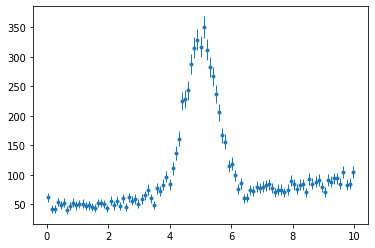

In [12]:
massbins = np.linspace(Mmin,Mmax, 100)
M_hist = histSqrtErrorBars(events[:,0], massbins, 'mass distribution')
#plt.plot(massbins, SignalMassNExt(massbins,bestMean,bestWidth,Nminuit)[1]/massbins.size , 'r-', label='best fit')
#plt.legend(loc='upper left')

Define a function to fit to the mass distribution, combining signal and background.

In [13]:
def CombinedMassNExt(xmass,smean,swidth,bc0,bc1,bc2,Ys,Yb):
  return ((Ys+Yb),Ys*SignalMassPDF(xmass,smean,swidth)+Yb*BackGPDF(xmass,[bc0,bc1,bc2]))

Perform Extended maximum likelihood fit to the mass distribution using iminuit optimiser.

In [14]:
from iminuit import Minuit, cost
from iminuit.cost import ExtendedUnbinnedNLL


In [15]:
mass_dist = events[:,0]

Ndata = mass_dist.size
mi = Minuit( ExtendedUnbinnedNLL(mass_dist, CombinedMassNExt), smean=5, swidth=0.5,bc0=0.6,bc1=0.2,bc2=0, Ys=Ndata/2,Yb=Ndata/2 )
mi.limits['Yb'] = (0,Ndata*1.1)
mi.limits['Ys'] = (0,Ndata*1.1)
mi.limits['smean'] = (Mmin,Mmax)
mi.limits['swidth'] = (0.01,Mmax-Mmin)
mi.limits['bc0'] = (-1,1)
mi.limits['bc1'] = (-1,1)
mi.limits['bc2'] = (-1,1)

#fix overall normalisation coefficeint to 1
#mi.fixed['bc0'] = True
#mi.fixed['bc0'] = True
mi.fixed['bc2'] = True

#do fitting
mi.migrad()

#save values
sg_mean=mi.values[0]
sg_width=mi.values[1]
bg_c0=mi.values[2]
bg_c1=mi.values[3]
bg_c2=mi.values[4]
Ysignal = mi.values[5]
Yback = mi.values[6]

display(mi)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.683e+05                 │              Nfcn = 156              │
│ EDM = 1.9e-05 (Goal: 0.0002)     │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ smean  │   5.000   │   0.012   │            │            │    0    │   10    │       │
│ 1 │ swidth │   0.507   │   0.011   │            │            │  0.01   │   10    │       │
│ 2 │ bc0    │    0.6    │    0.2    │            │            │   -1    │    1    │       │
│ 3 │ bc1    │   0.20    │   0.07    │            │            │   -1    │    1    │       │
│ 4 │ bc2    │    0.0    │    0.1    │            │            │   -1    │    1    │  yes  │
│ 5 │ Ys     │  3.37e3   │  0.08e3   │            │            │    0    │  11000  │       │
│ 6 │ Yb     │  6.63e3   │  0.10e3   │            │            │    0    │  11000  │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────┐
│        │      smean     swidth        bc0        bc1        bc2         Ys         Yb │
├────────┼──────────────────────────────────────────────────────────────────────────────┤
│  smean │   0.000153         -0          0   -0.01e-3          0    6.06e-3   -6.05e-3 │
│ swidth │         -0   0.000129          0          0          0  310.87e-3 -310.18e-3 │
│    bc0 │          0          0      0.041      0.014       0.00       0.01      -0.01 │
│    bc1 │   -0.01e-3          0      0.014     0.0048      0.000      0.008     -0.008 │
│    bc2 │          0          0       0.00      0.000          0        0e3        0e3 │
│     Ys │    6.06e-3  310.87e-3       0.01      0.008        0e3   5.96e+03       -3e3 │
│     Yb │   -6.05e-3 -310.18e-3      -0.01     -0.008        0e3       -3e3   9.21e+03 │
└────────┴──────────────────────────────────────────────────────────────────────────────┘

Plot the resulting fit function on top of the data

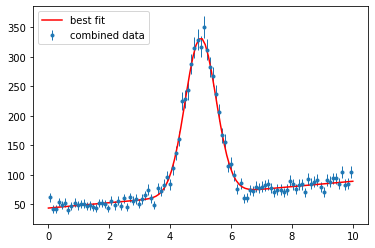

In [16]:
mass_hist = histSqrtErrorBars(mass_dist, massbins, 'combined data')
plt.plot(massbins, CombinedMassNExt(massbins,sg_mean,sg_width,bg_c0,bg_c1,bg_c2,Ysignal,Yback)[1]/massbins.size , 'r-', label='best fit')
plt.legend(loc='upper left')

We are going to use the sweights library provided by https://sweights.readthedocs.io/en/latest/about.html
This is related to the referenced paper on Custom Orthogonal Weight functions, of which sPlots is a specific case of. https://www.sciencedirect.com/science/article/pii/S0168900222006076?via%3Dihub

One issue with sweights is it requires zero dependence between the discriminatory and physics variables used and this is often not the case. The COWS method suggests a solution for the case where there is a dependence,.

In [17]:
from sweights import SWeight # for classic sweights

Remember the sWeights formula,


$   w_{t,k} = \frac{\sum_{t'}^{N_{t}} V_{tt'}.P_{t'}(x_{k}) }{\sum_{t'}^{N_{t}} Y_{t'}.P_{t'}(x_{k})}$

The SWeight() function will calculate the covariance matrix,

$ \left[ V_{tt'} \right]^{-1} = \frac{\partial ^2 \mathcal{ L}(\theta^{best}_{j},Y_{t})}{\partial Y_{t}Y_{t'}} = \sum^{N_{k}}_{k}\frac{P_{t}(x_{k})P_{t'}(x_{k})}{\left( \sum_{t'}^{N_{t}} Y_{t'}.P_{t'}(x_{k}) \right)^{2}}$

It can use either method, taking the approximate partial derivitives from a extended maximum likelihood fit, with method="roofit" $^{note}$ (left option) or by summing over the data events k with method="summation" (right option).


In [18]:
# create best value PDFs for signal and background
spdf = lambda m: SignalMassPDF(m,sg_mean,sg_width)
bpdf = lambda m: BackGPDF(m,[bg_c0,bg_c1,bg_c2])

# make the sweighter
mrange = (Mmin,Mmax)

sweighter = SWeight( mass_dist, [spdf,bpdf], [Ysignal,Yback], (mrange,), method='summation', compnames=('sig','bkg'), verbose=True, checks=True )

Initialising sweight with the summation method:
    PDF normalisations:
	 0 10.000000000000002
	 1 10.001711561848502
    W-matrix:
	[[2.07799969e-04 4.51839987e-05]
	 [4.51839987e-05 1.27870398e-04]]
    A-matrix:
	[[ 5212.84429857 -1841.99903577]
	 [-1841.99903577  8471.30296362]]
    Integral of w*pdf matrix (should be close to the
                identity):
	[[ 9.99957912e-01 -1.62195712e-05]
	 [ 4.90394888e-06  1.00004638e+00]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |  3371.0947 |  3371.0947 |    -0.00% |
	  1        |  6628.9799 |  6628.9799 |     0.00% |


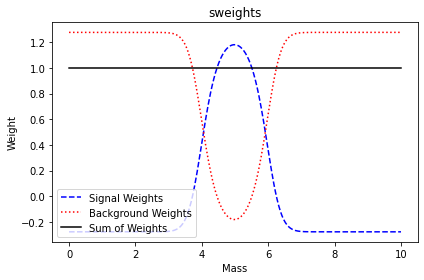

In [19]:
def plot_wts(x, sw, bw, title=None):
    fig,ax = plt.subplots()
    ax.plot(x, sw, 'b--', label='Signal Weights')
    ax.plot(x, bw, 'r:' , label='Background Weights')
    ax.plot(x, sw+bw, 'k-', label='Sum of Weights')
    ax.set_xlabel('Mass')
    ax.set_ylabel('Weight')
    if title: ax.set_title(title)
    fig.tight_layout()


# plot weights
xaxmass = np.linspace(*mrange,400)
swp = sweighter.get_weight(0,xaxmass)
bwp = sweighter.get_weight(1,xaxmass)
plot_wts(xaxmass, swp, bwp,"sweights")
plt.legend(loc='lower left')

Plot sWeighted phi distributions

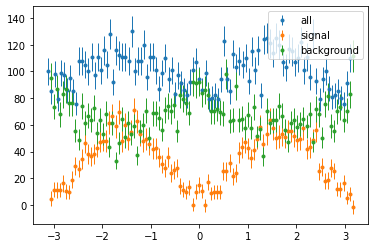

In [20]:
# Get signal only weights
sig_weights  = sweighter.get_weight(0, mass_dist)
# Get background only weights
bck_weights  = sweighter.get_weight(1, mass_dist)
#get phi data
phi_dist = events[:,1]
phibins = np.linspace(Phmin, Phmax, 100)

fig, ax = plt.subplots()
#draw offset sum squared weights errors
phi_all = histSqrtErrorBars(phi_dist, phibins, 'all')
phi_sig = histWeightedErrorBars(phi_dist, sig_weights, phibins, 'signal',0.05)
phi_bck = histWeightedErrorBars(phi_dist, bck_weights, phibins, 'background',0.05)
#draw true signal distribution
plt.legend(loc='upper right')


Now fit weighted signal distribution to see what we get for the asymmetry

In [21]:
sig_sumweights, edges = np.histogram( phi_dist, weights=sig_weights, bins=phibins )
sig_sumweight_sqrd, edges = np.histogram( phi_dist, weights=sig_weights*sig_weights, bins=phibins )
errors = np.sqrt(sig_sumweight_sqrd)
centres = (edges[:-1] + edges[1:]) / 2


In [22]:
#Unormalised Asymmetry
def AsymmetryN(xphi,Sigma,N):
  return N*AsymmetryPDF(xphi,Sigma)


Here we perform a Least Squares optimisation with weights. If uncertainties are correctly propogated we should get chi2/ndof =1 and an asymmetry of around 0.8 within its uncertainty

In [23]:
c = cost.LeastSquares(centres, sig_sumweights, errors, AsymmetryN)
m1 = Minuit(c, Sigma=0.1, N=Ysignal/edges.size )
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 74.79 (χ²/ndof = 0.8)      │              Nfcn = 59               │
│ EDM = 1.24e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Sigma │   0.767   │   0.028   │            │            │         │         │       │
│ 1 │ N     │    210    │     5     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │    Sigma        N │
├───────┼───────────────────┤
│ Sigma │ 0.000815 -29.5e-3 │
│     N │ -29.5e-3     20.7 │
└───────┴───────────────────┘